# Energy Policies Scrapping Project

[International Energy Agency website](https://www.iea.org/policies) contains information on past, existing or planned government policies and measures to reduce greenhouse gas emissions, improve energy efficiency and support the development and deployment of renewables and other clean energy technologies (see screenshot below). As of 9/21/2023, we can find information on 7815 policies on the website. They are presented on 261 pages with each page containing information 30 policies.

Task: to scrap information on abovementioned policies and save as a table in one of popular formats (for example, tsv file).

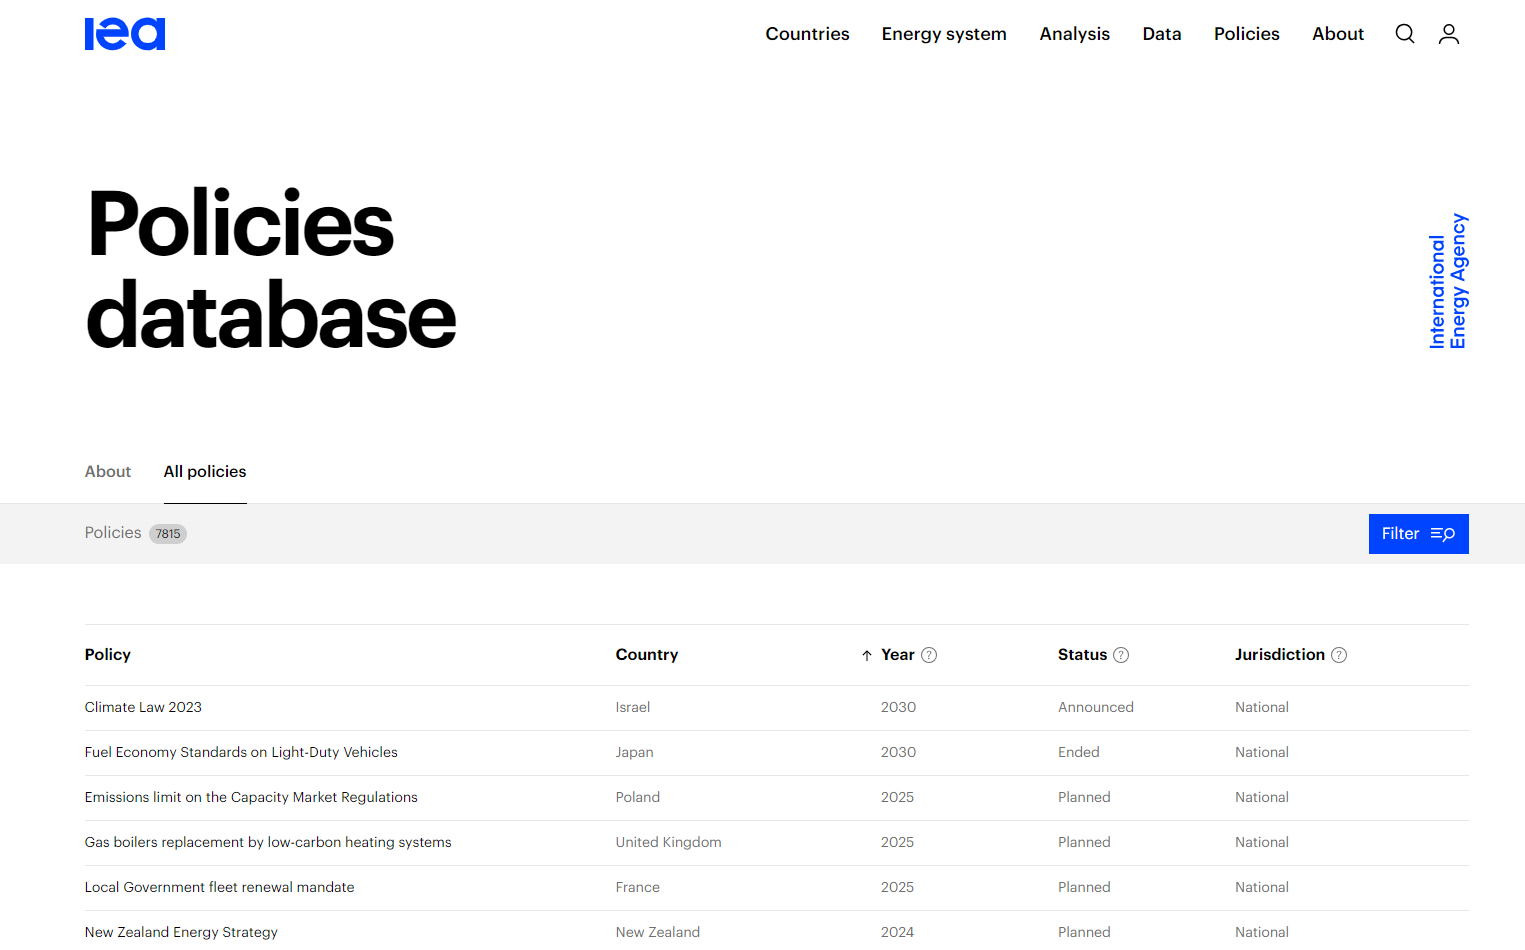

I start by importing some necessary libraries.

In [1]:
import requests
import lxml
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time

Now we can proceed with scraping. On each of 261 pages we can find the following information on energy policies:
 - policy name;
 - country adopting or planning a policy;
 - year of policy adoption (or planned year for adoption in future);
 - status of adoption;
 - jurisdiction (national or international policy level);
 - link to page policy details.
 
The page with policy details contains some additional useful details which can also be scrapped, namely the following tags:
 - topics covered by a policy;
 - policy type;
 - sector affected by a policy;
 - technologies used to conduct a policy.
 
Taking into account that I'm going to use multithreading in order to speed up scraping, I need a list of links to all pages to be scraped.

In [2]:
links = []
for page in range(1,262):
    links.append('https://www.iea.org/policies?page='+str(page))

Let's initialize a list that will contain all scraped information. 

In [3]:
data = []

The code below represents a function to be run in every page (actually in every thread within our multithreading).

In [4]:
def get_response(url):
    
    soup = BeautifulSoup(requests.get(url).text,'lxml')

    for row in soup.select('.m-policy-listing-item__row'):

        policy = row.find('a',class_='m-policy-listing-item__link').text.strip().replace('\r','').replace('\n','')

        link_to_policy = 'https://www.iea.org'+row.find('a')['href']

        country = row.find('span',class_='m-policy-listing-item__col m-policy-listing-item__col--country').text.strip()

        year = row.find('span',class_='m-policy-listing-item__col m-policy-listing-item__col--year').text.strip()

        status = row.find('span',class_='m-policy-listing-item__col m-policy-listing-item__col--status').text.strip()

        jurisdiction = row.find('span',class_='m-policy-listing-item__col m-policy-listing-item__col--jurisdiction').text.strip()

        soup2 = BeautifulSoup(requests.get(link_to_policy).text,'lxml')

        topics_string = '—'
        policy_types_string = '—'
        sectors_string = '—'
        technologies_string = '—'

        for tag_group in soup2.select('.m-policy-content__list'):

            if tag_group.find('span',class_='m-policy-content-list__title').text.strip() == 'Topics':
                topics = tag_group.find_all('span',class_='a-tag__label')
                topics_list = []
                for t in topics:
                    topics_list.append(t.text)
                if topics_string == '—':
                    topics_string = '; '.join(topics_list)

            if tag_group.find('span',class_='m-policy-content-list__title').text.strip() == 'Policy types':
                policy_types = tag_group.find_all('span',class_='a-tag__label')
                policy_types_list = []
                for pt in policy_types:
                    policy_types_list.append(pt.text)
                if policy_types_string == '—':
                    policy_types_string = '; '.join(policy_types_list)

            if tag_group.find('span',class_='m-policy-content-list__title').text.strip() == 'Sectors':
                sectors = tag_group.find_all('span',class_='a-tag__label')
                sectors_list = []
                for s in sectors:
                    sectors_list.append(s.text)
                if sectors_string == '—':    
                    sectors_string = '; '.join(sectors_list)

            if tag_group.find('span',class_='m-policy-content-list__title').text.strip() == 'Technologies':
                technologies = tag_group.find_all('span',class_='a-tag__label')
                technologies_list = []
                for tech in technologies:
                    technologies_list.append(tech.text)
                if technologies_string == '—':
                    technologies_string = '; '.join(technologies_list)

        data.append([country,year,status,jurisdiction,policy,topics_string,policy_types_string,sectors_string,technologies_string,link_to_policy])

The code below runs multithreading itself. As you can see, I added timer to control how long scraping process takes.

In [5]:
start_time = time.time()
with ThreadPoolExecutor() as executor:
    results = executor.map(get_response,links)
print(f"Scraping was completed in {(time.time() - start_time):.2f} seconds")

Scraping was completed in 849.69 seconds


Scraping with multithreading was completed in 14 min. Also, I tried to scrap without multithreading and it took approximately 1 hour 20 minutes for the code to complete running. So the advantages of multithreading are obvious.

Let's see an example how scraped data looks like.

In [6]:
data[:2]

[['Slovak Republic',
  '2023',
  'In force',
  'National',
  'Compensation for electricity and gas providers of small off-takers',
  'Energy Poverty',
  'Grants',
  'Power; Heat and Utilities',
  '—',
  'https://www.iea.org/policies/17127-compensation-for-electricity-and-gas-providers-of-small-off-takers'],
 ['Israel',
  '2030',
  'Announced',
  'National',
  'Climate Law 2023',
  'Renewable Energy',
  'Targets; plans and framework legislation',
  'Economy-wide (Multi-sector)',
  '—',
  'https://www.iea.org/policies/17194-climate-law-2023']]

By the way, I assured that information on all 7815 policies was scraped. 

In [7]:
len(data)

7815

I used pandas to present scraped data as a table. The order of column names in a header is the same as the order of respective information in the list *data*.

In [8]:
df = pd.DataFrame(data,columns=['Country','Year','Status','Jurisdiction','Policy Name','Policy Topics','Policy Types','Related Sectors','Related Technologies','Link to Policy Description'])

Let's see how the beginning of the table looks like.

In [9]:
df.head(40)

,Country,Year,Status,Jurisdiction,Policy Name,Policy Topics,Policy Types,Related Sectors,Related Technologies,Link to Policy Description
0,Slovak Republic,2023,In force,National,Compensation for electricity and gas providers...,Energy Poverty,Grants,Power; Heat and Utilities,—,https://www.iea.org/policies/17127-compensatio...
1,Israel,2030,Announced,National,Climate Law 2023,Renewable Energy,Targets; plans and framework legislation,Economy-wide (Multi-sector),—,https://www.iea.org/policies/17194-climate-law...
2,Denmark,2023,In force,National,Power-to-X tender,Renewable Energy,"Payments, finance and taxation; Payments and t...","Power, Heat and Utilities; Hydrogen production...",Hydrogen; Hydrogen electrolysis technologies,https://www.iea.org/policies/15185-power-to-x-...
3,People's Republic of China,2023,In force,National,Subsidy on New Energy Vehicle 2023,Electrification,"Payments, finance and taxation; Payments and t...",Transport; Road transport,Drive train or engine; Battery electric; Trans...,https://www.iea.org/policies/17536-subsidy-on-...
4,Sweden,2022,In force,National,Climate Premium for environmental vehicles,Air Quality; Electrification,"Payments, finance and taxation; Grants",Transport; Road transport; Passenger transport...,Road vehicles; Vehicle type,https://www.iea.org/policies/14846-climate-pre...
5,United States,2022,In force,State/Provincial,(Louisiana) Climate Action Plan,Methane abatement,Strategic plans; Climate change strategies,Economy-wide (Multi-sector),—,https://www.iea.org/policies/17037-louisiana-c...
6,Kenya,2022,In force,National,2022 Reduction of electricity tariffs,—,Tariff design,Electricity distribution,—,https://www.iea.org/policies/16827-2022-reduct...
7,France,2023,In force,National,Green Fund for the local acceleration in ecolo...,Air Quality; Cities; Energy Efficiency,"Payments, finance and taxation; Funds to sub-n...",Buildings; Transport; Road transport; Public a...,—,https://www.iea.org/policies/16430-green-fund-...
8,Finland,2022,In force,National,Electrification aid for energy-intensive indus...,—,—,—,—,https://www.iea.org/policies/16406-electrifica...
9,Poland,2022,In force,National,Anti-Inflation Shield: low-income household su...,Energy Poverty,Grants,Power; Heat and Utilities,Heating; cooling and climate control technologies,https://www.iea.org/policies/16728-anti-inflat...


Looks good, so I proceed with saving it as tsv file.

In [11]:
df.to_csv('./energy-policies-database.tsv',sep='\t',encoding='utf-8-sig')